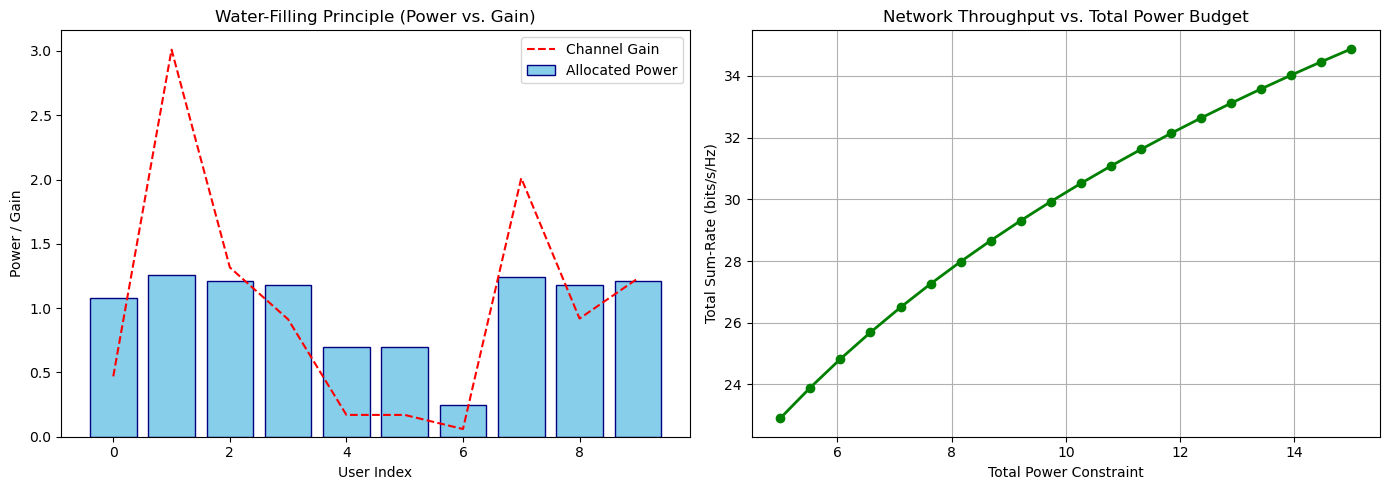

In [5]:
# --- Base Power Allocation ---
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

# 1. Simulation Parameters
np.random.seed(42)   # Seed ensures reproducible channel gains
N_users = 10
P_max = 10.0         # Total Power Budget (High enough to ensure feasibility)
noise_power = 0.1    # Noise variance
min_rate = 0.2       # Minimum bits/s/Hz for QoS/Resilience

gains = np.random.exponential(1.0, N_users)

# 2. Optimization Formulation
P = cp.Variable(N_users)

# Objective: Maximize sum-rate
objective = cp.Maximize(cp.sum(cp.log(1 + (cp.multiply(P, gains)) / noise_power) / np.log(2)))

# Constraints
min_power = (noise_power * (2**min_rate - 1)) / gains
constraints = [
    cp.sum(P) <= P_max,
    P >= min_power 
]

# Solve
prob = cp.Problem(objective, constraints)
prob.solve()

# 3. Safety Check & Visualization
if prob.status != cp.OPTIMAL:
    print(f"Warning: Problem is {prob.status}! Try increasing P_max or lowering min_rate.")
else:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot A: Water-Filling
    ax1.bar(range(N_users), P.value, color='skyblue', edgecolor='navy', label='Allocated Power')
    ax1.plot(range(N_users), gains, 'r--', label='Channel Gain')
    ax1.set_title("Water-Filling Principle (Power vs. Gain)")
    ax1.set_xlabel("User Index")
    ax1.set_ylabel("Power / Gain")
    ax1.legend()

    # Plot B: Throughput Analysis
    power_budgets = np.linspace(5.0, 15.0, 20)
    throughputs = []
    
    for p_budget in power_budgets:
        P_loop = cp.Variable(N_users)
        prob_loop = cp.Problem(
            cp.Maximize(cp.sum(cp.log(1 + (cp.multiply(P_loop, gains)) / noise_power) / np.log(2))),
            [cp.sum(P_loop) <= p_budget, P_loop >= min_power]
        )
        try:
            prob_loop.solve()
            throughputs.append(prob_loop.value if prob_loop.status == cp.OPTIMAL else np.nan)
        except cp.error.SolverError:
            throughputs.append(np.nan)

    # This is the line that got cut off previously!
    ax2.plot(power_budgets, throughputs, 'g-o', linewidth=2)
    ax2.set_title("Network Throughput vs. Total Power Budget")
    ax2.set_xlabel("Total Power Constraint")
    ax2.set_ylabel("Total Sum-Rate (bits/s/Hz)")
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

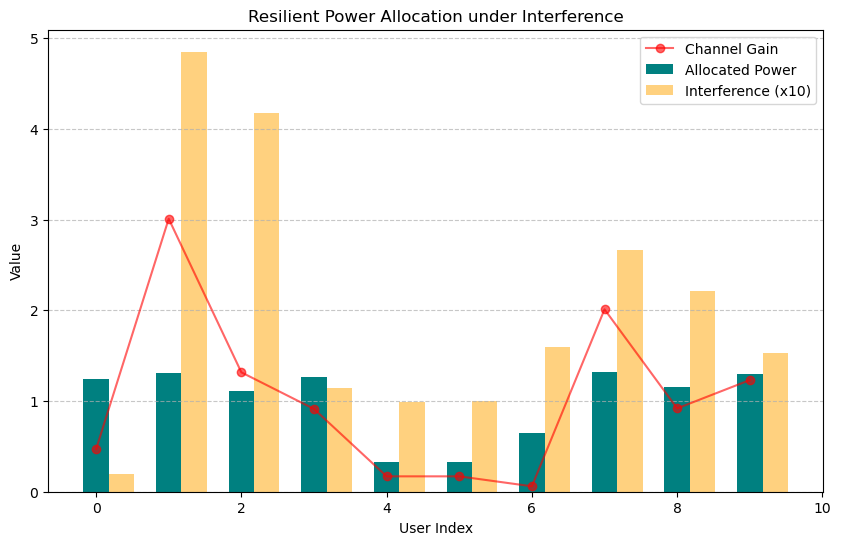

In [6]:
# --- Interference-Aware Power Allocation ---

# 1. Simulation Parameters (Adding Interference)
interference = np.random.uniform(0.01, 0.5, N_users) # Random interference per user

# 2. Optimization Formulation
P_int = cp.Variable(N_users)

# Objective: SINR-based Sum-Rate
sinr = cp.multiply(P_int, gains) / (noise_power + interference)
objective_int = cp.Maximize(cp.sum(cp.log(1 + sinr) / np.log(2)))

# Constraints: Power + Resilience (QoS) adjusted for Interference
min_power_int = ((noise_power + interference) * (2**min_rate - 1)) / gains
constraints_int = [
    cp.sum(P_int) <= P_max,
    P_int >= min_power_int 
]

prob_int = cp.Problem(objective_int, constraints_int)
prob_int.solve()

# 3. Visualization
if prob_int.status != cp.OPTIMAL:
    print(f"Warning: Problem is {prob_int.status}! Try increasing P_max.")
else:
    plt.figure(figsize=(10, 6))
    bar_width = 0.35
    indices = np.arange(N_users)

    plt.bar(indices, P_int.value, bar_width, label='Allocated Power', color='teal')
    plt.plot(indices, gains, 'ro-', label='Channel Gain', alpha=0.6)
    plt.bar(indices + bar_width, interference * 10, bar_width, label='Interference (x10)', color='orange', alpha=0.5)

    plt.title("Resilient Power Allocation under Interference")
    plt.xlabel("User Index")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

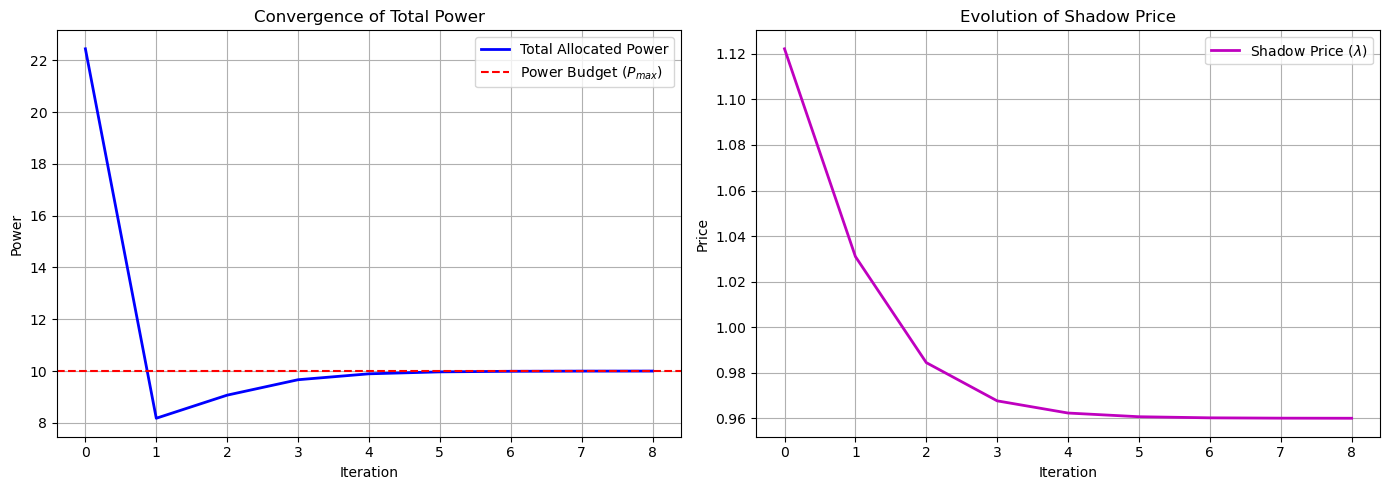

In [8]:
# --- Distributed Optimization via Dual Decomposition ---

# 1. Setup Decentralized Variables
noise_plus_interference = noise_power + interference
lmbda = 0.5           # Initial shadow price of power
step_size = 0.05      # Learning rate for dual update (tuned for stability)
max_iter = 200
tolerance = 1e-3

# 2. Optimization Loop
history_power = []
history_lambda = []

for k in range(max_iter):
    # Local Subproblem: Each user optimizes their own power based on 'lambda'
    # Derived from setting the derivative of the Lagrangian to 0
    p_opt = (1 / (lmbda * np.log(2))) - (noise_plus_interference / gains)
    
    # Apply non-negativity and QoS constraint
    p_opt = np.maximum(p_opt, min_power_int)
    
    # Master Problem: Network updates Lambda based on constraint violation
    total_power = np.sum(p_opt)
    error = total_power - P_max
    
    # Update lambda (increase if power budget exceeded, decrease otherwise)
    lmbda = np.maximum(lmbda + step_size * error, 1e-6)
    
    history_power.append(total_power)
    history_lambda.append(lmbda)
    
    if abs(error) < tolerance:
        break

# 3. Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot A: Convergence of Total Power
ax1.plot(history_power, 'b-', linewidth=2, label='Total Allocated Power')
# FIXED: Added 'r' before the string to properly render LaTeX
ax1.axhline(y=P_max, color='r', linestyle='--', label=r'Power Budget ($P_{max}$)')
ax1.set_title("Convergence of Total Power")
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Power")
ax1.legend()
ax1.grid(True)

# Plot B: Convergence of Shadow Price
# FIXED: Added 'r' before the string to properly render LaTeX
ax2.plot(history_lambda, 'm-', linewidth=2, label=r'Shadow Price ($\lambda$)')
ax2.set_title("Evolution of Shadow Price")
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Price")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()